In [1]:
import sys
sys.path.append('/home/emastr/phd/')
import numpy as np
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft
from matplotlib import pyplot as plt
from jax import grad, jit, vmap
#from numpy.fft import fft, ifft
from multiprocessing import Pool
from util.logger import EventTracker

In [2]:
def split(data, n):
    N = data.shape[0]
    return [data[i*N//n:(i+1)*N//n] for i in range(n)]
            
def self_eval(*args):
    """arg[0] = function
       arg[1] through arg[n] = arguments to function"""
    return args[0](*args[1:])

PROC = 60
def paralellize(func, x, yfft, y):
    yfft_split, y_split  = split(yfft, PROC), split(y, PROC)
    with Pool(PROC) as p:
        data = p.starmap(self_eval, [(func, x, yfft_i, y_i) for yfft_i, y_i in zip(yfft_split, y_split)])
    return np.mean(data)

def autocorr(x):
    return ifft(autocorr_fft(fft(x)))


def trunc(xfft, k):
    xfft.at[1+k:-k].set(0.)
    return xfft


def autocorr_fft(xfft):
    return jnp.abs(xfft) ** 2


def find_shifts(xfft, yfft):
    return jnp.argmax(ifft(xfft * yfft.conj(), axis=1).real, axis=1)


def align(xfft, yfft, y):
    shift_rec = find_shifts(xfft, yfft)
    y_shift = jnp.vstack([np.roll(y_i, s_i) for y_i, s_i in zip(y, shift_rec)])
    return y_shift


def project_moments(xfft, acf_fft, mean):
    xfft = xfft.at[0].set(mean)
    xfft = xfft.at[1:].set(xfft[1:] * acf_fft[1:]**0.5 / jnp.abs(xfft[1:]))
    return xfft


def mean_and_project(xfft, yfft, y, acf_fft, mean):
    y_shift = align(xfft, yfft, y)
    x = jnp.mean(y_shift, axis=0)
    xfft = project_moments(fft(x), acf_fft, mean)
    return xfft

def loss_fourier_(xfft, yfft, y):
    y_shift = align(xfft, yfft, y)
    return xfft.shape[0]  **2 * jnp.mean(jnp.abs(y_shift - ifft(xfft))**2) / 2

def loss_real_(x, yfft, y):
    y_shift = align(fft(x), yfft, y)
    return x.shape[0] * jnp.mean(jnp.abs(y_shift - x)**2) / 2


def shift_cont(yfft, shifts):
    """Shift signals according to shifts. Shifts should be complex numbers on the unit circle."""
    assert yfft.shape[0] == len(shifts), "Must have same length as signal"
    d = yfft.shape[1]
    powers = np.arange(0, d, 1)
    shifts = shifts[:, None] ** powers[None, :]
    return yfft * shifts


def loss_cont(xfft, yfft, shifts):
    yfft_shifted = shift_cont(yfft, shifts)
    return jnp.mean(jnp.abs(xfft - yfft_shifted)**2).real

grad_loss_ = grad(loss_fourier_)
grad_loss_real_ = grad(loss_real_)
grad_loss_cont_ = grad(loss_cont, argnums=[0,2])



#grad_loss = lambda x, yfft, y: paralellize(grad_loss_, x, yfft, y)
#grad_loss_real = lambda x, yfft, y: paralellize(grad_loss_real_, x, yfft, y)
#grad_loss_cont = lambda x, yfft, y: paralellize(grad_loss_cont_, x, yfft, y)
#loss_fourier = lambda x, yfft, y: paralellize(loss_fourier_, x, yfft, y)
#loss_real = lambda x, yfft, y: paralellize(loss_real_, x, yfft, y)

grad_loss = grad_loss_
grad_loss_real = grad_loss_real_
grad_loss_cont = grad_loss_cont_
loss_fourier = loss_fourier_
loss_real = loss_real_

############## METHODS ###################################


def fix_point_iter(x0, yfft, y, acf_fft, mean, tol, maxiter, alpha=0.5, callback=None):
    res = tol + 1.
    i = 0
    xfft = fft(x0)
    while (res > tol) and i < maxiter:
        xfft_new = (1 - alpha) * xfft + alpha * mean_and_project(xfft, yfft, y, acf_fft, mean)
        res = jnp.mean(jnp.abs(xfft-xfft_new))
        xfft = xfft_new
        i += 1
        if callback is not None:
            callback(xfft, res, i)
    return ifft(xfft).real


def projected_gradient_descent_fourier(x0, yfft, y, acf_fft, mean, step, tol, maxiter, callback=None, logger=None):
    res = tol + 1
    i = 0
    
    xfft = fft(x0)
    while (res > tol) and (i < maxiter):
        
        if logger is not None:
            logger.start_event("grad_loss")
        xfft_new = project_moments(xfft - step * jnp.conjugate(grad_loss(xfft, yfft, y)), acf_fft, mean)
        if logger is not None:
            logger.end_event("grad_loss")
        
        if logger is not None:
            logger.start_event("residual")
        res = jnp.mean(jnp.abs(xfft - xfft_new))
        if logger is not None:
            logger.end_event("residual")
        i += 1
        xfft = xfft_new

        if logger is not None:
            logger.start_event("callback")
        if callback is not None:
            callback(xfft, res, i)
        if logger is not None:
            logger.end_event("callback")

    return ifft(xfft).real



def projected_gradient_descent_real(x0, yfft, y, acf_fft, mean, step, tol, maxiter, callback=None):
    res = tol + 1
    i = 0
    
    x = x0
    while (res > tol) and (i < maxiter):
        x_new = ifft(project_moments(fft(x - step * jnp.conjugate(grad_loss_real(x, yfft, y))), acf_fft, mean))
        res = jnp.mean(jnp.abs(x - x_new))
        i += 1
        x = x_new

        if callback is not None:
            callback(fft(x), res, i)

    return x.real


def projected_newton_descent(x0, yfft, y, acf_fft, mean, step, tol, maxiter, callback=None):
    res = tol + 1
    i = 0
    
    xfft = fft(x0)
    while (res > tol) and (i < maxiter):
        xfft_new = project_moments(xfft - step * jnp.conjugate(grad_loss(xfft, yfft, y)) / (acf_fft**0.5 + 0.1) * np.linalg.norm(acf_fft)**0.5, acf_fft, mean)
        res = jnp.mean(jnp.abs(xfft - xfft_new))
        i += 1
        xfft = xfft_new

        if callback is not None:
            callback(xfft, res, i)

    return ifft(xfft).real


def cont_projected_gradient_descent(x0, yfft, acf_fft, mean, step, tol, maxiter, callback=None):
    res = tol + 1.
    i = 0
    d = len(x0)

    xfft = fft(x0)
    shifts = find_shifts(xfft, yfft)
    shifts = jnp.exp(-2j * np.pi * shifts / d)


    #### NYQUIST FREQUENCY SET 0? 
    #### NEGATIVE SHIFTS INSTEAD OF POSITIVE?
    
    while (res > tol) and (i < maxiter):
        grad_x, grad_shift = grad_loss_cont(xfft, yfft, shifts)
        xfft_new = project_moments(xfft - step * jnp.conjugate(grad_x), acf_fft, mean)
        shifts = shifts - 10*step * jnp.conjugate(grad_shift)
        shifts = shifts / jnp.abs(shifts)

        res = jnp.mean(jnp.abs(xfft_new - xfft))
        xfft = xfft_new
        i += 1

        if callback is not None:
            callback(xfft, res, i)

    return ifft(xfft).real, shifts


In [3]:
logger = EventTracker()
d = 41
N=int(1e4)
noise=1.


#d = 5
#N = int(4e3)
#noise = 1/2.**0.5#1.#1.#1.

## GENERATE SIGNAL
t = np.linspace(0, 2*np.pi, d+1)[:-1]
x = (t < np.pi).astype(float) 
#x = np.exp(4 * jnp.sin(t))
#x = x / np.linalg.norm(x) * np.sqrt(d)

shift = np.random.randint(0, d, N)
y = np.vstack([jnp.roll(x, s) for s in shift])
y = y + np.random.randn(*y.shape) * noise

## FOURIER TRANSFORM
xfft = fft(x)
yfft = fft(y, axis=1)

# Moments
acf_fft = jnp.clip(jnp.mean(np.abs(yfft)**2, axis=0) - noise**2 * d, 0, None)
mean = jnp.mean(yfft[:, 0])

x0 = y[0, :].copy()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
print('### FIX POINT ITERATIONS ###')
iter_fp = []
losses_fp = []
def cb_fp(xfft, res, it):
    losses_fp.append(loss_fourier(xfft, yfft, y))
    iter_fp.append(xfft.copy())
    print(f"step {it}. res: {res}, loss: {losses_fp[-1]}", end="\r")


x_fp = fix_point_iter(x0, yfft, y, acf_fft, mean, alpha=1.0, tol=0, maxiter=100, callback=cb_fp)

print('\n### PROJECTED GRADIENT DESCENT ###')
iter_pg = []
losses_pg = []
def cb_pg(xfft, res, it):
    losses_pg.append(loss_fourier(xfft, yfft, y))
    iter_pg.append(xfft.copy())
    print(f"step {it}. res: {res}, loss: {losses_pg[-1]}", end="\r")

x_pg = projected_gradient_descent_fourier(x0, yfft, y, acf_fft, mean, step=2., tol=0, maxiter=10, callback=cb_pg, logger=logger)

print('\n### PROJECTED HESSIAN ###')
iter_pn = []
losses_pn = []
def cb_ph(xfft, res, it):
    iter_pn.append(xfft.copy())
    losses_pn.append(loss_fourier(xfft, yfft, y))
    print(f"step {it}. res: {res}, loss: {losses_pn[-1]}", end="\r")

x_pn = projected_newton_descent(x0, yfft, y, acf_fft, mean, step=0.3, tol=1e-10, maxiter=10, callback=cb_ph)

print('\n### JOINT GRADIENT ###')
iter_jg = []
losses_jg = []
def cb_jg(xfft, res, it):
    iter_jg.append(xfft.copy())
    losses_jg.append(loss_fourier(xfft, yfft, y))
    print(f"step {it}. res: {res}, loss: {losses_jg[-1]}", end="\r")

x_jg, _ = cont_projected_gradient_descent(x0, yfft, acf_fft, mean, step=1.0, tol=1e-5, maxiter=4, callback=cb_jg)

### FIX POINT ITERATIONS ###
step 100. res: 0.007693936116993427, loss: 811.8618164062525
### PROJECTED GRADIENT DESCENT ###
step 10. res: 0.05447812005877495, loss: 812.2620239257812
### PROJECTED HESSIAN ###
step 10. res: 0.18648363649845123, loss: 812.743652343755
### JOINT GRADIENT ###


Event: grad_loss, calls: 10, time: 4.872628211975098 s, mean time:0.4872628211975098 s.
Event: residual, calls: 10, time: 0.0004928112030029297 s, mean time:4.928112030029297e-05 s.
Event: callback, calls: 10, time: 4.332655429840088 s, mean time:0.43326554298400877 s.


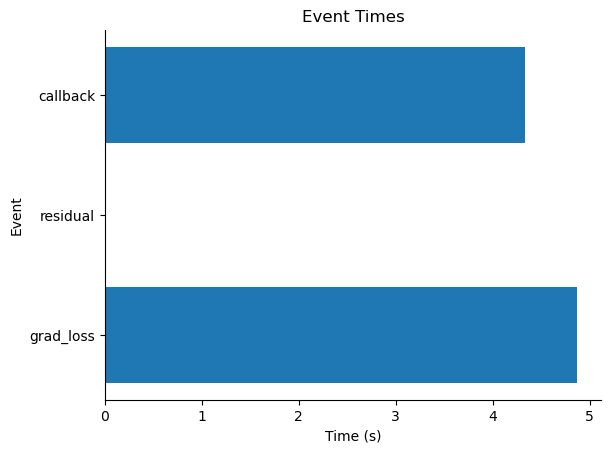

In [5]:
logger.barplot_logs(plt.gca())
logger.print_logs()

[ 9.50735033e-01  1.03989720e+00  1.04411936e+00  9.67058301e-01
  1.03764009e+00  1.01737773e+00  1.02060127e+00 -3.03640589e-03
 -3.21555696e-03  1.59535278e-02  3.57767427e-03 -5.76014630e-03
 -1.86287947e-02 -2.53482442e-02 -1.08685374e-01  3.16646211e-02
 -1.07123493e-03  3.87220904e-02  4.90210913e-02 -1.57830909e-01
  8.33379291e-03 -5.93694858e-03 -3.49546447e-02  1.87970810e-02
  2.84097735e-02 -4.86441255e-02  1.51172981e-01  1.03354144e+00
  9.49574530e-01  1.07128084e+00  9.95942593e-01  1.01665831e+00
  9.50717807e-01  9.73348439e-01  9.18911219e-01  1.02836609e+00
  1.02031326e+00  9.97191966e-01  9.97977793e-01  9.80196953e-01
  9.60341811e-01]
Fix Point: 0.06962157549700367
Projected Gradient: 0.10883029394181352
Projected Newton: 0.09151092704164585
Joint Gradient: 0.245571346362502


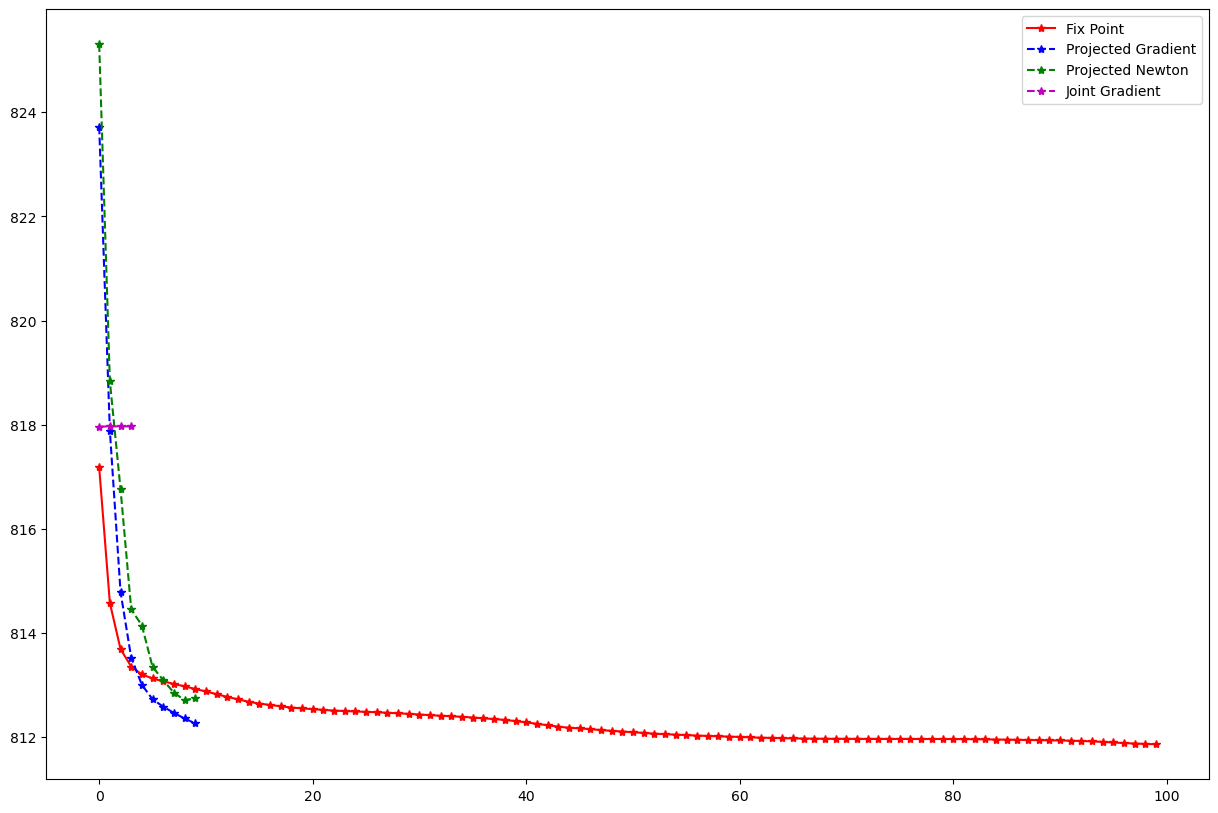

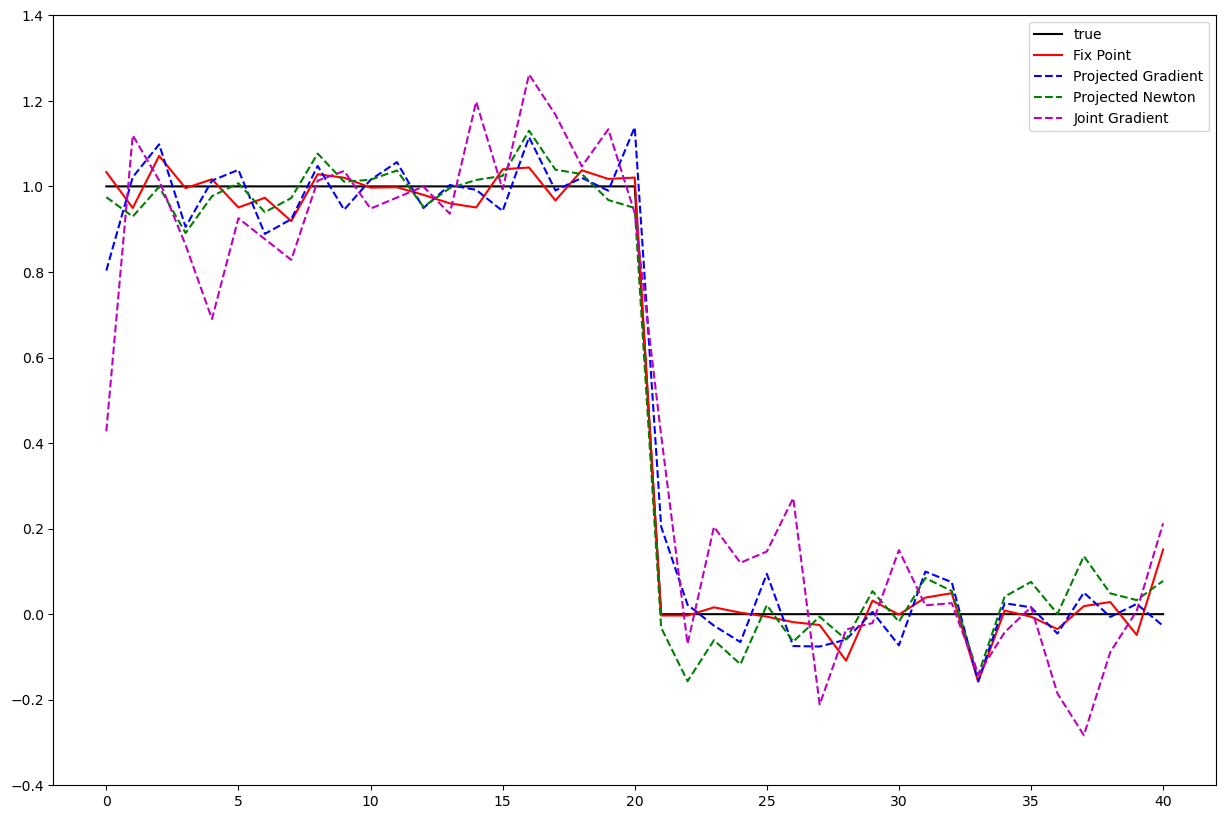

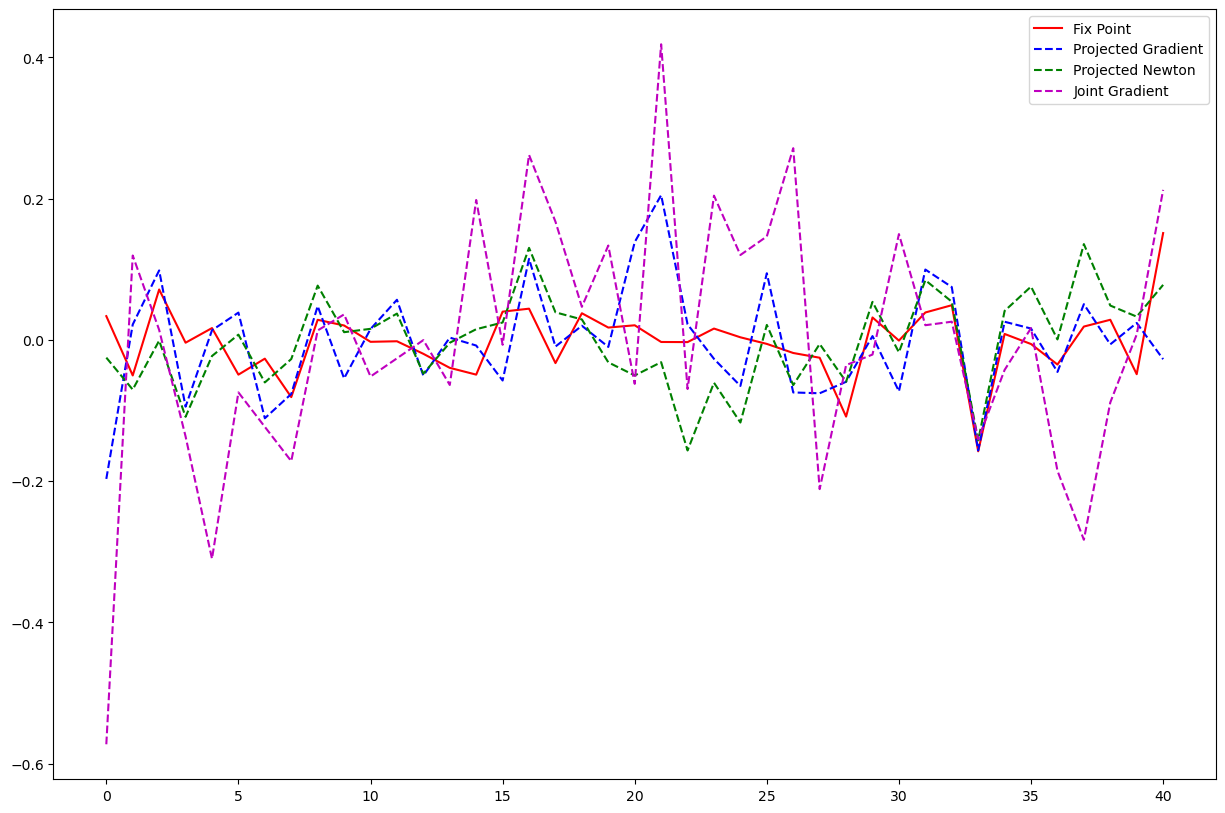

In [6]:
xs = [x_fp, x_pg, x_pn, x_jg]
print(x_fp)
names = ['Fix Point', 'Projected Gradient', 'Projected Newton', 'Joint Gradient']
losses = [losses_fp, losses_pg, losses_pn, losses_jg]
linestyles = ['r-', 'b--', 'g--', 'm--']

plt.figure(1, figsize=(15,10))
plt.figure(2, figsize=(15,10))
plt.plot(x, 'k', label='true')
plt.figure(3, figsize=(15,10))

for xi, li, ni, ls in zip(xs, losses, names, linestyles):
    x_al = align(fft(x), fft(xi)[None, :], xi[None, :])[0].real
    
    print(f"{ni}: {np.linalg.norm(x - x_al)/np.linalg.norm(x)}")
    
    plt.figure(1)
    plt.plot(li, ls + '*', label=ni)    

    plt.figure(2)
    plt.plot(x_al, ls, label=ni)
    
    plt.figure(3)
    plt.plot(x_al-x, ls, label=ni)

plt.figure(1)
plt.legend()

plt.figure(2)
plt.legend()
plt.ylim([min(x)-0.4, max(x)+0.4])

plt.figure(3)
plt.legend()



### Signal size 5

Below code only works for signal size 5

In [7]:
from multiprocessing import Pool, cpu_count

xfft_abs_apx = acf_fft ** 0.5

def get_angles(signal):
    fft_sig = np.fft.fft(signal)
    return np.angle(fft_sig[4]), np.angle(fft_sig[3])

def create_signal(angle1, angle2):
    e1 = np.exp(1j * angle1)
    e2 = np.exp(1j * angle2)
    return np.array([mean,
     e1 * xfft_abs_apx[1],
     e2 * xfft_abs_apx[2],
     e2.conj() * xfft_abs_apx[3],
     e1.conj() * xfft_abs_apx[4]])
    
    
def find_shifts_np(xfft, yfft):
    return jnp.argmax(np.fft.ifft(xfft * yfft.conj(), axis=1).real, axis=1)


def align_np(xfft, yfft, y):
    shift_rec = find_shifts_np(xfft, yfft)
    y_shift = jnp.vstack([np.roll(y_i, s_i) for y_i, s_i in zip(y, shift_rec)])
    return y_shift


def loss_np(xfft, yfft, y):
    y_shift = align_np(xfft, yfft, y)
    return np.mean((y_shift - ifft(xfft))**2).real
    
angle1s, angle2s = np.meshgrid(np.linspace(0, 2*np.pi, 100), np.linspace(0, 2*np.pi, 100))

def loss_map(args):
    a1, a2 = args[0], args[1]
    return loss_np(create_signal(a1, a2), yfft, y)


In [8]:
pool = Pool(50)
losses = np.array(pool.map(loss_map, zip(angle1s.flatten(), angle2s.flatten()))).reshape(*angle1s.shape)
#losses = np.array([find_loss(ifft(create_signal(a1, a2)), yfft, y) for a1, a2 in zip(angle1s.flatten(), angle2s.flatten())]).reshape(*angle1s.shape)
#find_loss(x, yfft, y)

Fix Point:(5.09893214652263, 0.7378358672020358)
Projected Gradient:(1.3317409431868397, 5.763028776562345)
Projected Newton:(5.043059458649308, 0.6465222992717397)
Joint Gradient:(4.921840284584374, 1.7971209484156472)


(0.0, 2.0)

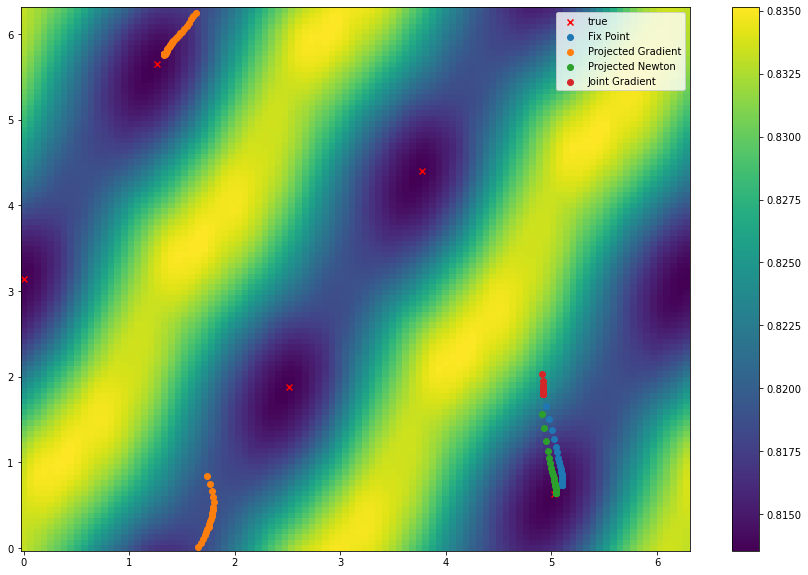

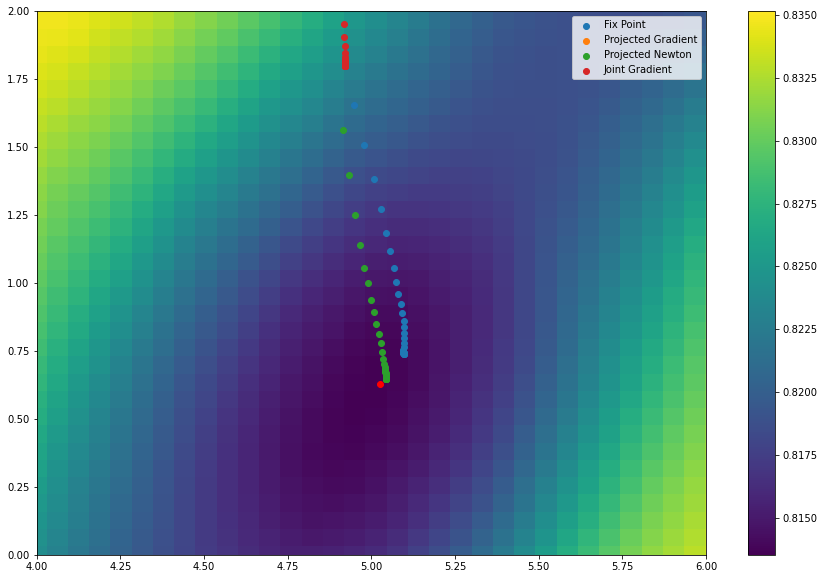

In [ ]:
plt.figure(figsize=(15,10))
plt.pcolormesh(angle1s, angle2s, losses.real)
plt.colorbar()

for s in range(5):
    x_roll = np.roll(x, s)
    angle1, angle2 = get_angles(x_roll)
    plt.scatter(angle1 % (2*np.pi), angle2 % (2*np.pi), c='r', marker='x', label='true' if s==0 else None)

for iter_i, n_i, ls_i in zip([iter_fp, iter_pg, iter_pn, iter_jg], names, linestyles):
    angles = [get_angles(ifft(xfft)) for xfft in iter_i]
    angle0 = np.array([a[0] for a in angles]) % (2*np.pi)
    angle1 = np.array([a[1] for a in angles]) % (2*np.pi)
    #plt.plot(angle0, angle1, ls_i, label=n_i)
    plt.scatter(angle0, angle1, label=n_i)


plt.legend()

plt.figure(figsize=(15,10))
plt.pcolormesh(angle1s, angle2s, losses.real)
plt.colorbar()
for s in range(5):
    x_roll = np.roll(x, s)
    angle1, angle2 = get_angles(x_roll)
    plt.scatter(angle1 % (2*np.pi), angle2 % (2*np.pi), c='r')

#max_
angs = []
for iter_i, n_i, ls_i in zip([iter_fp, iter_pg, iter_pn, iter_jg], names, linestyles):
    angles = [get_angles(ifft(xfft)) for xfft in iter_i]
    angle0 = np.array([a[0] for a in angles]) % (2*np.pi)
    angle1 = np.array([a[1] for a in angles]) % (2*np.pi)
    
    print(f"{n_i}:{angle0[-1], angle1[-1]}")
    #max_a0, min_a0 = max(max(angle0), max_a0), min(min(angle0), min_a0)
    angs.append((angle0[-1], angle1[-1]))
    #plt.plot(angle0, angle1, ls_i, label=n_i)
    plt.scatter(angle0, angle1, label=n_i)

plt.legend()
plt.xlim([4,6])
plt.ylim([0,2])

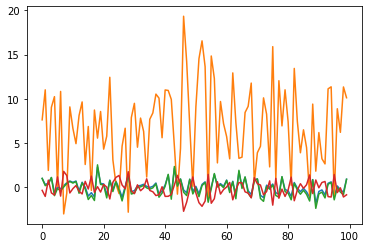

In [ ]:
y = np.random.randn(100) + 1j * np.random.randn(100)

def loss_func(x):
    return jnp.mean(((x - y)*jnp.conjugate(x - y)).real)

grad_loss = grad(loss_func)

x = jnp.ones_like(y)*(1 + 1j)
for i in range(100):
    x = x - 0.9 * grad_loss(x)

plt.plot(x.real)
plt.plot(x.imag)
plt.plot(y.real)
plt.plot(y.imag)

In [ ]:

y = 1 + 1j
x = 2 + 2j

def loss_func(x):
    return jnp.abs(x - y)**2

grad_loss = grad(loss_func)

for i in range(10):
    x = x - 0.9 * jnp.conjugate(grad_loss(x))
    print(x)

(0.20000017+0.20000017j)
(1.6399999+1.6399999j)
(0.48800015+0.48800015j)
(1.4095998+1.4095998j)
(0.6723202+0.6723202j)
(1.2621439+1.2621439j)
(0.79028493+0.79028493j)
(1.167772+1.167772j)
(0.8657824+0.8657824j)
(1.1073741+1.1073741j)


In [ ]:
r = jnp.zeros((3,))
r.at[0].set(1)
r

DeviceArray([0., 0., 0.], dtype=float32)